In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install statsmodels==0.12.2

     |████████████████████████████████| 9.5 MB 4.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd

DATA_PATH = '/content/drive/My Drive/my_colab/'
AMZN_DATA = f'{DATA_PATH}AMZN/AMZN.csv'

amzn_df = pd.read_csv(AMZN_DATA, parse_dates=['Date'])

amzn_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900
1,2010-01-05,133.429993,135.479996,131.809998,134.690002,134.690002,8851900
2,2010-01-06,134.600006,134.729996,131.649994,132.250000,132.250000,7178800
3,2010-01-07,132.009995,132.320007,128.800003,130.000000,130.000000,11030200
4,2010-01-08,130.559998,133.679993,129.029999,133.520004,133.520004,9830500


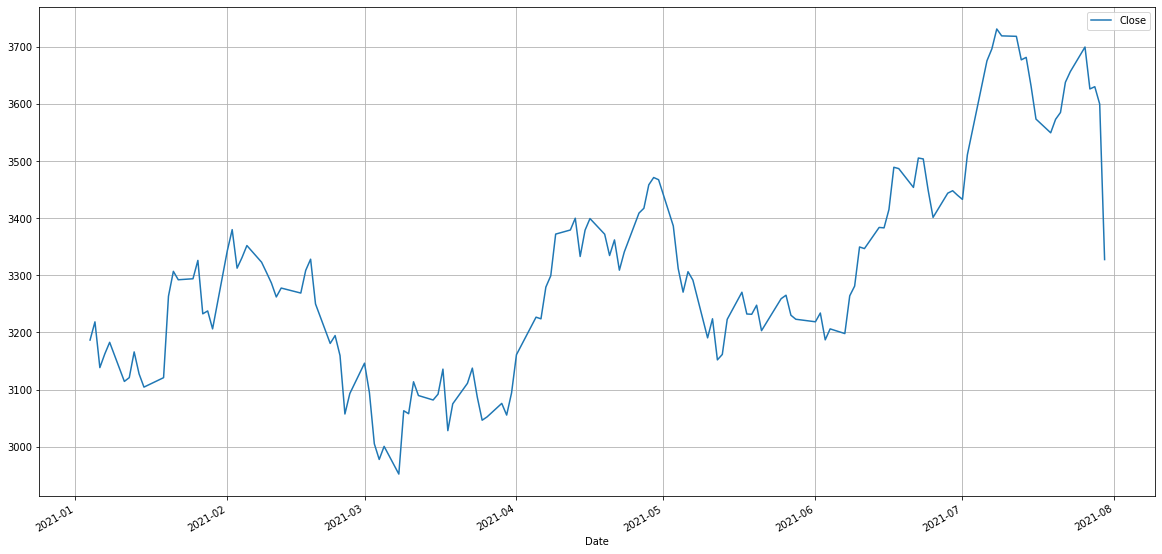

In [ ]:
def plot_dt_window(df, dt_col, start=None, end=None):
    start = str(df[dt_col].min()) if start is None else start
    end = str(df[dt_col].max()) if end is None else end
    window_df = df[(df[dt_col] >= start) & (df[dt_col] <= end)]
    window_df.set_index(dt_col).plot(figsize=(20,10), grid=True)

plot_dt_window(amzn_df[['Date','Close']], 'Date', '2021', None)

Let's try different exponential smoothing methods for stock price forecasting

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels
import numpy as np
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
from sklearn.model_selection import ParameterGrid
import random
import warnings
warnings.filterwarnings("ignore")

def mean_absolute_percentage_error(y_true, y_pred): 
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

def exp_smoothing(df, type, feature, horizon=None, lag_opt=None, fill_gaps=False, period='D'):
  exp_types = ('simple', 'double', 'tripple')
  assert type in exp_types, f'type is not valid. Possible types: {exp_types}'

  if fill_gaps:
    df = df.resample(period).asfreq().ffill()
  
  train = df[-(lag_opt+horizon):-horizon]

  if type == 'simple':
    model = SimpleExpSmoothing(train, initialization_method="estimated").fit()
  elif type == 'double':
    model = Holt(train, initialization_method="estimated").fit()
  elif type == 'tripple':
    model = ExponentialSmoothing(train, seasonal='add',trend='add', initialization_method="estimated").fit()

  y_smooth = model.forecast(horizon)

  mape = mean_absolute_percentage_error(df[-horizon:][feature].values, y_smooth)
  return mape, y_smooth


def optimize_lag_and_plot_smoothing(df_src, dt_col, feature_name, period='D', horizon=31):
  df = df_src[[dt_col, feature_name]].copy()
  df = df.set_index(dt_col)
  df.index = pd.DatetimeIndex(df.index).to_period(period) 

  params_grid = {'type':['simple', 'double', 'tripple'],
                'lag_opt':[horizon * mul for mul in range(1, 10)]}

  grid = ParameterGrid(params_grid)
  model_parameters = pd.DataFrame(columns = ['type','mape','params'])

  for p in grid:
    random.seed(0)  
    mape, y_smooth = exp_smoothing(df, p['type'], feature_name, horizon=horizon, lag_opt=p['lag_opt'], fill_gaps=False, period=period)
    model_parameters = model_parameters.append({'type':p['type'], 'mape':mape, 'params':p}, ignore_index=True)

  parameters = model_parameters.sort_values(by=['mape'])
  parameters = parameters.reset_index(drop=True)

  simple_best = parameters[parameters['type']=='simple'].iloc[0]
  double_best = parameters[parameters['type']=='double'].iloc[0]
  tripple_best = parameters[parameters['type']=='tripple'].iloc[0]

  simple_best_lag_opt = simple_best['params']['lag_opt']
  double_best_lag_opt = double_best['params']['lag_opt']
  tripple_best_lag_opt = tripple_best['params']['lag_opt']

  simple_mape, y_simple = exp_smoothing(df, 'simple', feature_name, horizon=horizon, lag_opt=simple_best_lag_opt, fill_gaps=False, period=period)
  double_mape, y_double = exp_smoothing(df, 'double', feature_name, horizon=horizon, lag_opt=double_best_lag_opt, fill_gaps=False, period=period)
  tripple_mape, y_tripple = exp_smoothing(df, 'tripple', feature_name, horizon=horizon, lag_opt=tripple_best_lag_opt, fill_gaps=False, period=period)

  df_tgt = df_src[[dt_col, feature_name]].copy()
  df_tgt = df_tgt.set_index(dt_col)
  df_tgt =  df_tgt[-horizon*2:].copy()

  df_simple = df_src[[dt_col]].copy()
  df_simple = df_simple.set_index(dt_col)
  df_simple =  df_simple[-horizon:].copy()
  df_simple[f'Simple exponential smoothing, MAPE {simple_mape}, lag_opt {simple_best_lag_opt}'] = y_simple.values

  df_double = df_src[[dt_col]].copy()
  df_double = df_double.set_index(dt_col)
  df_double =  df_double[-horizon:].copy()
  df_double[f'Double exponential smoothing, MAPE {double_mape}, lag_opt {double_best_lag_opt}'] = y_double.values

  df_tripple = df_src[[dt_col]].copy()
  df_tripple = df_tripple.set_index(dt_col)
  df_tripple =  df_tripple[-horizon:].copy()
  df_tripple[f'Tripple exponential smoothing, MAPE {tripple_mape}, lag_opt {tripple_best_lag_opt}'] = y_tripple.values

  pd.plotting.register_matplotlib_converters()
  with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.rcParams.update({'font.size': 12})
    plt.plot(df_tgt, label=feature_name)
    plt.plot(df_simple, label=df_simple.columns[0])
    plt.plot(df_double, label=df_double.columns[0])
    plt.plot(df_tripple, label=df_tripple.columns[0])
    plt.vlines(df_tgt.index[-horizon], ymin=min(df_tgt.values), ymax=max(df_tgt.values), linestyles='dashed')
    plt.legend(loc="best")
    plt.legend(frameon=True)
    plt.margins(x=0)
    plt.axis('tight')
    plt.title("Exponential smoothing")
    plt.grid(True)

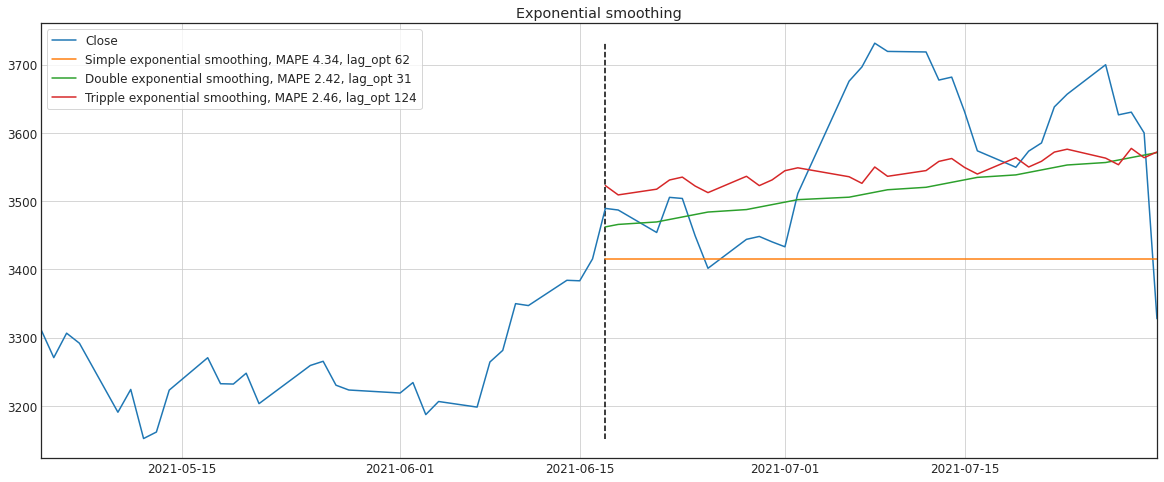

In [ ]:
optimize_lag_and_plot_smoothing(amzn_df, 'Date', 'Close')